# ERA5 Growth Rate Computation

## import pacakge

In [43]:
import sys
import numpy as np
import joblib as jl
import netCDF4 as nc

from matplotlib import pyplot as plt
from scipy.signal import convolve2d

sys.path.append('/home/b11209013/Package/')
import Theory as th
import DataProcess as dp
import SignalProcess as sp

## Functions

### Covariance

In [44]:
ft = sp.Fourier()

def Covariance(data1, data2):
    # Compute the cross-spectrum
    cs = ft.CrossSpectrum(data1, data2)
    
    # Define the smoothing kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16  # 2D kernel
    
    # Smooth using 2D convolution
    cs_smooth = convolve2d(cs.real, kernel, mode='same') + 1j * convolve2d(cs.imag, kernel, mode='same')
    
    return cs_smooth

### Phase

In [45]:
def Phase(data1, data2):
    
    cs = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ])
    
    phase = np.atan2(cs.imag, cs.real)
    
    return phase

### Growth Rate

In [46]:
def Growth_Rate(data1, data2):
    
    var = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    
    sigma = 2*np.real(cov) / var
    
    return sigma

### Coherence Square

In [47]:
def Coherence(data1, data2):
    
    var1 = np.array([
        Covariance(data1[i], data1[i]).real
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    var2 = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov  = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    
    Coh2 = ((cov.real)**2 + (cov.imag)**2) / (var1 * var2)

    return Coh2

## Load data

In [48]:
fpath: str = '/work/b11209013/2024_Research/nstcCCKW/'

var_list: list[str] = ['q1pc1', 'q1pc2', 'tpc1', 'tpc2']

data : dict[str]= {}

with nc.Dataset(f'{fpath}Q1/Q1PC.nc', 'r', mmap=True) as f:
    lat          : np.ndarray = f.variables['lat'][:]
    lon          : np.ndarray = f.variables['lon'][:]
    lat_lim = np.where((lat>=-5)&(lat<=5))[0]
    lat = lat[lat_lim]
    data['q1pc1']: np.ndarray = f.variables['q1pc1'][:, :, lat_lim, :]*86400/1004.5
    data['q1pc2']: np.ndarray = f.variables['q1pc2'][:, :, lat_lim, :]*86400/1004.5
    
with nc.Dataset(f'{fpath}t/tPC.nc', 'r', mmap=True) as f:
    data['tpc1']: np.ndarray = f.variables['tpc1'][:, :, lat_lim, :]
    data['tpc2']: np.ndarray = f.variables['tpc2'][:, :, lat_lim, :]

print(data['tpc1'].shape)

(42, 132, 20, 576)


## Format data

### Form symmetric data

In [49]:
fmt = dp.Format(lat)

sym: dict[str] = {}

for var in var_list:
    sym[var] : np.ndarray = np.array([fmt.sym(data[var][s])
    for s in range(data[var].shape[0])
    ])
print(sym['q1pc1'].shape)

(42, 132, 576)


### Windowing data

In [50]:
hanning = np.hanning(96)[None, :, None]

windowing: dict[str] = {}

for var in var_list:
    windowing[var]: np.ndarray = np.concatenate(
        np.array([
        sym[var][:, i*36:i*36+96]
        for i in range(2)
    ]),
    axis=0
    )
print(windowing['q1pc1'].shape)

(84, 96, 576)


## Compute Variabels

### Phase

In [51]:
phase = {
    'pc1': Phase(
        windowing['tpc1'], windowing['q1pc1']
    ),
    'pc2': Phase(
        windowing['tpc2'], windowing['q1pc2']
    )
}

### Growth Rate

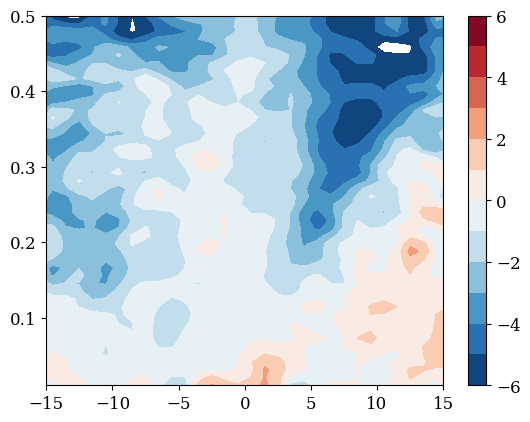

In [52]:
sigma = {
    'pc1': Growth_Rate(
        windowing['q1pc1'], windowing['tpc1']
    ),
    'pc2': Growth_Rate(
        windowing['q1pc2'], windowing['tpc2']
    ),
}

fr = np.linspace(1/96, 1/2, 48)
wn = np.linspace(-288, 288, 576)
plt.contourf(wn, fr, sigma['pc1'], cmap='RdBu_r', levels=np.linspace(-6, 6, 13))
plt.xlim(-15, 15)
plt.colorbar()

### Coherences

In [53]:
Coh2 = {
    'pc1': Coherence(windowing['q1pc1'], windowing['tpc1']),
    'pc2': Coherence(windowing['q1pc2'], windowing['tpc2']),
}

### Fisher's Z

In [54]:
def z_transform(coh2):
    r = np.sqrt(coh2)

    return np.log((1+r)/(1-r))

Z_trans = {
    'pc1': z_transform(Coh2['pc1']),
    'pc2': z_transform(Coh2['pc2']),
}

## Statistics Test

In [55]:
criteria = {
    'pc1': Z_trans['pc1'].mean() + 1.96*Z_trans['pc1'].std(),
    'pc2': Z_trans['pc2'].mean() + 1.96*Z_trans['pc2'].std(),
}

sigma_filted = {
    'pc1': np.where(Z_trans['pc1'] >= criteria['pc1'], sigma['pc1'], np.nan),
    'pc2': np.where(Z_trans['pc2'] >= criteria['pc2'], sigma['pc2'], np.nan),
}

## Plot Diagram

### plot Setting

In [56]:
wn = np.linspace(-288, 288, 576)
fr = np.linspace(1/96, 1/2, 48)

wnm, frm = np.meshgrid(wn, fr)

plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

### Growth Rate

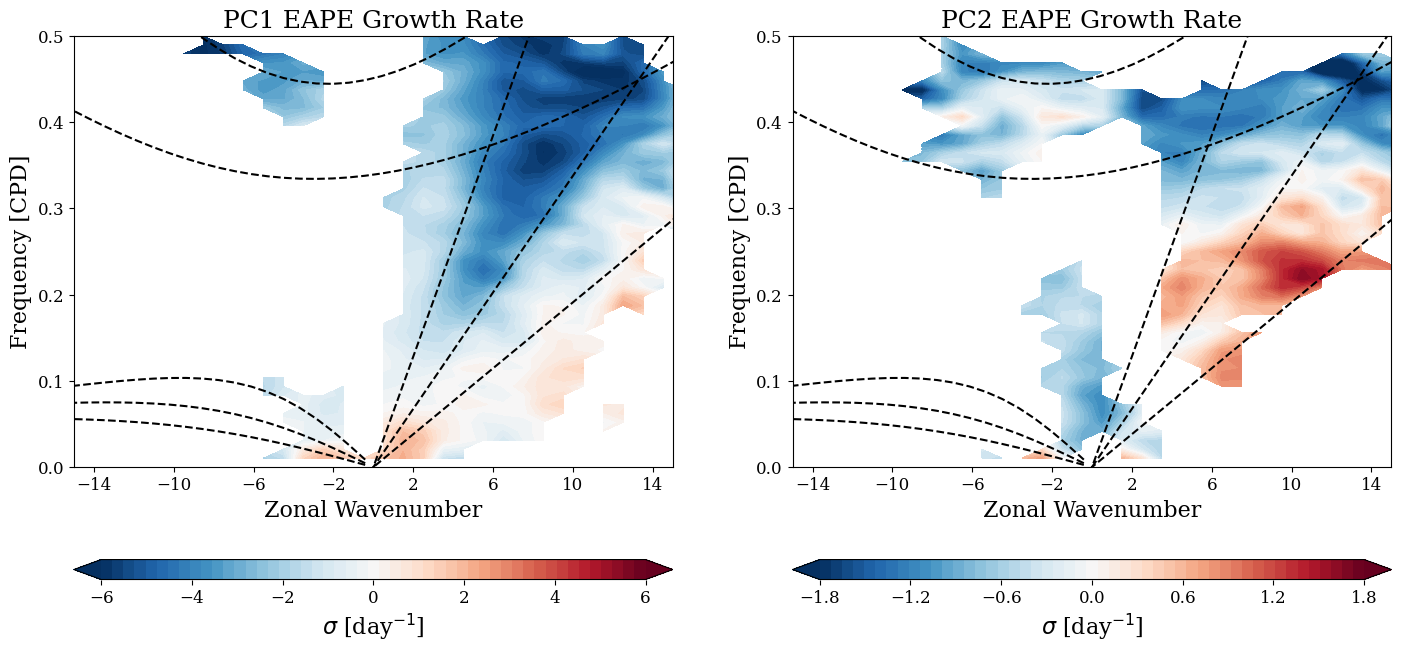

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
c1 = ax[0].contourf(
    wnm, frm, 
    sigma_filted['pc1'],
    levels=np.linspace(-6, 6),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    ax[0].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[0].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[0].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[0].set_xticks(np.linspace(-14, 14, 8))
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 0.5)
ax[0].set_xlabel('Zonal Wavenumber')
ax[0].set_ylabel('Frequency [CPD]')
ax[0].set_title(f'PC1 EAPE Growth Rate')
cbar1 = plt.colorbar(
    c1,
    ax=ax[0],
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar1.set_ticks(np.linspace(-6, 6, 7))

c2 = ax[1].contourf(
    wnm, frm, 
    sigma_filted['pc2'],
    levels=np.linspace(-1.8, 1.8),
    cmap="RdBu_r",
    extend='both'
)
for i in range(3):
    ax[1].plot(wn_ana[3, i, e_cond], fr_ana[3, i, e_cond], 'k--')
    ax[1].plot(wn_ana[4, i, :], fr_ana[4, i, :], 'k--')
    ax[1].plot(wn_ana[5, i, :], fr_ana[5, i, :], 'k--')
ax[1].set_xticks(np.linspace(-14, 14, 8))
ax[1].set_yticks(np.linspace(0, 0.5, 6))
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 0.5)
ax[1].set_xlabel('Zonal Wavenumber')
ax[1].set_ylabel('Frequency [CPD]')
ax[1].set_title(f'PC2 EAPE Growth Rate')
cbar2 = plt.colorbar(
    c2,
    ax=ax[1],
    aspect=30,
    orientation='horizontal',
    label=r'$\sigma$ [day$^{-1}$]'
)
cbar2.set_ticks(np.linspace(-1.8, 1.8, 7))
plt.savefig('Growth_Rate.svg')